In [397]:
import numpy as np 
import pandas as pd
import regex as re
import unicodedata as ud
import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import wordpunct_tokenize
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import multiprocessing
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

## Movies Datasets

In [434]:
forties_df = pd.read_csv('1940s_data/1940s_movies.csv')
fifties_df = pd.read_csv('1950s_data/1950s_movies.csv')
sixties_df = pd.read_csv('1960s_data/1960s_movies.csv')
seventies_df = pd.read_csv('1970s_data/1970s_movies.csv')

#### EDA functions

In [3]:
def describe_dataframe(df):
    
    for column in df.columns:
        print('Column Name: ', u'\u202B' + str(column) + u'\u202C')
        print(df[column].describe())
        print('\n'+'-'*20)

#### Cleansing functions

In [4]:
def change_empty_entries_to_None(df):
    for column in df.columns:
        for row_index in range(df.shape[0]):
            if '??' in str(df.loc[row_index, column]) or \
            df.loc[row_index, column] == 'nan' or \
            df.loc[row_index, column] == '-' or \
            type(df.loc[row_index, column]) == float:
                    df.loc[row_index, column] = None
    return df
    

In [5]:
def fix_float_types(df):
    for row in range(df.shape[0]):
        if(df.loc[row, 'ملخص'] == 'nan' or ''):
            df.loc[row]['ملخص'] = np.nan
        if(df.loc[row, ' تصنيف الفيلم'] == 'nan' or ''):
            df.loc[row]['تصنيف الفيلم'] = np.nan
    return df

In [6]:
def get_indices_to_drop(df, column_name):
    indices = []
    for row_index in range(df.shape[0]):
        cell_content = df.loc[row_index,column_name]
        if(type(cell_content)== float):
            indices.append(row_index)
    return indices

In [7]:
def unify_date_format(df):
    for row in range(df.shape[0]):
        
        release_day = df.iloc[row, 15]
        if len(str(release_day)) == 4:
            df.iloc[row,17] = release_day
            df.iloc[row,16] = 'يناير'

    return df

In [8]:
def expand_release_date(df):
    # line continuation operators  '\' used for cleaner code
    df[['اليوم', 'الشهر', 'السنة']] = \
    df[' تاريخ العرض'].str.split(' ', expand = True)
    
    return df
    

In [9]:
def find_movies_with_missing_synopses(df):
    
    missing_movies = []
    for row_index in range(df.shape[0]):
        if(type(df.iloc[row_index, 3]) == float):
            missing_movies.append(df.iloc[row_index, 0])
            
    return missing_movies

In [10]:
def parse_line(line_to_parse):
    
            parsed_values = line_to_parse.split('||')
            movie_name_date = parsed_values[0].strip(')').split('(')
            
            name = movie_name_date[0]
            year = movie_name_date[1]
            df_feature = parsed_values[1]
            
            return name, year, df_feature

In [11]:
def add_scraped_features(df, file_path, column_name):
    
    with open(file_path, 'r') as filehandle:
        
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, df_feature = parse_line(current_line)
            if(not(df_feature == '')):
                df.loc[(df['اسم الفيلم'] == name) \
                     & (df['السنة'] == year), column_name] = df_feature     
    return df

In [12]:
def filter_foregin_movies(df, file_path):
    
    with open(file_path, 'r') as filehandle:
            
        for line in filehandle:
            
            current_line = line[:-1]
            name, year, country = parse_line(current_line)
           
            if(not(('مصر') in country)):   
                movie_index = df.loc[(df['اسم الفيلم'] == name) \
                                     & (df['السنة'] == year)].index
                df.drop(inplace = True, index = movie_index)
    return df

In [13]:
def get_avg_short_movie_time(df):
    
    short_movies_durations = df[' مدة الفيلم (دقيقة)'].loc[ \
                                    df[' تصنيف الفيلم'] == 'ﻗﺼﻴﺮ']
    avg_duration = np.average(list(short_movies_durations))
    
    return avg_duration

In [14]:
def get_missing_percentage(df):
    
    total_count = df.shape[0]
    for column in df.columns:
    
        missing_count = movies_df[column].isna().sum()
        missing_percentage = (missing_count/total_count)*100
        print('>> ' + u'\u202B' + column + ': '+ str(round(missing_percentage)) + '%')

## *_1940s Movies_*

### EDA

In [15]:
describe_dataframe(forties_df)

Column Name:  ‫اسم الفيلم‬
count             331
unique            330
top       خاتم سليمان
freq                2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫ تاريخ العرض‬
count      331
unique     216
top       1946
freq        24
Name:  تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       127
unique        9
top       ??ا??
freq         46
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    331.000000
mean     106.399698
std       11.097976
min       70.000000
25%      100.000000
50%      105.000000
75%      110.000000
max      152.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count                                                   316
unique                                                  316
top       يكافح وحيد الملحن الشاب (فريد الاطرش) مع أخته ...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column

In [16]:
forties_df.loc[forties_df['اسم الفيلم'] == 'خاتم سليمان']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
174,خاتم سليمان,1946,NaN,103.2,NaN,أبو بثينة,أمينة شريف,أفلام حرب,NaN,NaN,NaN,NaN,NaN,فؤاد شبل,NaN
227,خاتم سليمان,1947,ا????ا??,117.0,تناول الفيلم في إطار من الخيال، قصة المعلم بيو...,"حسن رمزي,السيد زيادة","ليلى مراد,يحيى شاهين,زكي رستم,نيللي مظلوم,ثريا...",أفلام النصر (محمد حسن رمزي وشركاه),"مصطفى حسن,وحيد فريد","ألبير نجيب,وفيقة أبو جبل",حبيب خوري,قاسم وجدي,"حسين السيد,السيد زيادة,رياض السنباطي,محمد القص...","حسن رمزي,ألبير نجيب,عبدالرحمن شريف",NaN


In [17]:
forties_df['التصنيف'].value_counts()

??ا??       46
???????     26
??????      25
ا????ا??    16
?????        7
تاريخي       2
?????ا?      2
????         2
???          1
Name: التصنيف, dtype: int64

### Cleansing

In [142]:
forties_df = change_empty_entries_to_None(forties_df)

In [143]:
forties_df['التصنيف'].value_counts()

تاريخي    2
Name: التصنيف, dtype: int64

In [144]:
expanded_date_40s = forties_df.copy(deep = True)

In [145]:
expanded_date_40s = expand_release_date(forties_df)
expanded_date_40s = unify_date_format(expanded_date_40s)

In [146]:
expanded_date_40s = expanded_date_40s.drop(columns=[' تاريخ العرض','اليوم'])
expanded_date_40s['التقييم'] = None

In [147]:
foreigns_filtered_40s  = expanded_date_40s.copy(deep = True)

In [148]:
foreigns_filtered_40s = filter_foregin_movies(expanded_date_40s \
                                                , '1940s_data/countries_1940s.txt')

In [149]:
genre_added_40s = foreigns_filtered_40s.copy(deep = True)

In [150]:
genre_added_40s = add_scraped_features(foreigns_filtered_40s \
                                          , '1940s_data/1940s_genres.txt' \
                                         , 'التصنيف')

In [152]:
genre_added_40s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                75
ﻛﻮﻣﻴﺪﻱ               23
موسيقي / استعراضي    13
ﺭﻭﻣﺎﻧﺴﻲ              12
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          2
ﻋﺎﺋﻠﻲ                 2
ﺟﺮﻳﻤﺔ                 2
ﻣﻐﺎﻣﺮاﺕ               1
ﺣﺮﺏ                   1
ﺧﻴﺎﻝ                  1
Name: التصنيف, dtype: int64

In [153]:
ratings_added_40s = genre_added_40s.copy(deep = True)

In [154]:
ratings_added_40s = add_scraped_features(genre_added_40s \
                                          , '1940s_data/1940s_ratings.txt' \
                                         , 'التقييم')

In [155]:
synopsis_added_40s = ratings_added_40s.copy(deep = True)

In [156]:
synopsis_added_40s = add_scraped_features(ratings_added_40s \
                                          , '1940s_data/1940s_synopses.txt' \
                                         , 'ملخص')

In [157]:
synopsis_added_40s = synopsis_added_40s.reset_index(drop=True)

In [158]:
synopsis_added_40s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
61,ابنتي,ﺩﺭاﻣﺎ,135.0,يبدد زوج ناهد أموال زوجته على عشيقته، وبعد أن ...,"أحمد رامي,عزيزة أمير,محمود ذو الفقار","عزيزة أمير,محمود ذو الفقار,زكي طليمات,فردوس مح...","أفلام عزيزة أمير,رمسيس نجيب,ستوديو نصيبيان","مصطفى حسن,وحيد فريد,أرام ماراليان",جلال مصطفى,"روبرت شارفنبرج,حبيب خوري,عباس حلمي,أبو العلا علي",None,"محمد الكحلاوي,إبراهيم حسن,حامد طاهر,عبدالعزيز ...","نيازي مصطفى,محمد عبدالجواد,فهمي عبدالجواد",نحّاس فيلم,ابريل,1944,6.2


## *_1950s Movies_*

In [ ]:
fifties_df.sample(10)

In [29]:
describe_dataframe(fifties_df)

Column Name:  ‫اسم الفيلم‬
count              534
unique             533
top       هل أقتل زوجى
freq                 2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫ تاريخ العرض‬
count      534
unique     368
top       1953
freq        14
Name:  تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       383
unique       11
top       ??ا??
freq        138
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    534.000000
mean     108.119663
std       13.207141
min       53.000000
25%      100.000000
50%      108.350000
75%      115.000000
max      170.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ ملخص‬
count                                                   522
unique                                                  522
top       تدور أحداث الفيلم حو حلاق في بغداد يحكي لزبائن...
freq                                                      1
Name:  ملخص, dtype: object

--------------------


In [31]:
fifties_df['التصنيف'].value_counts()

??ا??           138
??????           85
???????          80
ا????ا??         34
?????            17
تاريخي           10
????             10
???               4
???? ????         2
?????ا?           2
????? ??????      1
Name: التصنيف, dtype: int64

In [32]:
fifties_df[fifties_df.duplicated(subset = ['اسم الفيلم'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
441,هل أقتل زوجى,5 مايو 1958,NaN,87.0,تبدأ أحداث الفيلم بجو هادئ مرح فى أسرة مكونة م...,محمد كامل حسن المحامي,"محسن سرحان,سميرة أحمد,توفيق الدقن,سهير البابلي...","وليم رزق,حسن موافى,فرغل البارودي,حسام الدين مصطفى","البير رياض,كليليو (ك. ستشفللي)",حسن حلمي (حسنوف),"أنطوان بوليزويس,عبدالمنعم على",NaN,NaN,"حسام الدين مصطفى,سيمون صالح,مصطفى سمهان,إبراهي...",NaN


In [33]:
fifties_df.loc[fifties_df['اسم الفيلم'] == 'غرام في إستانبول (غرام في إسطنبول)']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع


In [159]:
fifties_df = change_empty_entries_to_None(fifties_df)

In [160]:
expanded_date_50s = fifties_df.copy(deep = True)

In [161]:
expanded_date_50s = expand_release_date(fifties_df)
expanded_date_50s = unify_date_format(expanded_date_50s)

In [162]:
expanded_date_50s.drop(columns=[' تاريخ العرض','اليوم'], inplace = True)
expanded_date_50s['التقييم'] = None

In [163]:
foreign_filtered_50s = expanded_date_50s.copy(deep = True)

In [164]:
foreign_filtered_50s = filter_foregin_movies(expanded_date_50s
                                               , '1950s_data/countries_1950s.txt')

In [165]:
ratings_added_50s = foreign_filtered_50s.copy(deep = True)

In [166]:
ratings_added_50s = add_scraped_features(foreign_filtered_50s \
                                           , '1950s_data/1950s_ratings.txt'
                                           , 'التقييم')

In [167]:
genres_added_50s = ratings_added_50s.copy(deep = True)

In [168]:
genres_added_50s = add_scraped_features(ratings_added_50s \
                                           , '1950s_data/1950s_genres.txt'
                                           , 'التصنيف')

In [169]:
synopsis_added_50s = genres_added_50s.copy(deep = True)

In [170]:
synopsis_added_50s = add_scraped_features(genres_added_50s \
                                          , '1950s_data/1950s_synopses.txt' \
                                         , 'ملخص')

In [41]:
synopsis_added_50s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                60
ﺭﻭﻣﺎﻧﺴﻲ               44
موسيقي / استعراضي     31
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          14
تاريخي                 9
ﺟﺮﻳﻤﺔ                  8
ﺣﺮﻛﺔ                   6
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              3
ﻋﺎﺋﻠﻲ                  3
ﻏﻤﻮﺽ                   2
ﺣﺮﺏ                    2
ﺭﻋﺐ                    1
ﺧﻴﺎﻝ                   1
ﻣﻐﺎﻣﺮاﺕ                1
Name: التصنيف, dtype: int64

In [171]:
synopsis_added_50s = synopsis_added_50s.reset_index(drop=True)

In [172]:
synopsis_added_50s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
5,فلفل,ﺩﺭاﻣﺎ,95.0,يجري دكتور تجارب على الأصوات وينشغل عن زوجته ا...,"مصطفى العطار,حسن توفيق,سيف الدين شوكت","إسماعيل يس,حسن فايق,ماجدة,لولا صدقي,إلياس مؤدب...","معامل شبرا,محسن سابو","مسعود عيسى,فيكتور أنطون,ماركو","أحمد إسماعيل,فيرتشي أورفانللي","سليمان شاهين,ستوديوهات (حدائق) شبرا",None,"حسن توفيق,حسن أبو زيد","سيف الدين شوكت,مصطفى العطار,أنيس نهرا,إلياس متى",None,مارس,1950,5


## *_1960s Movies_*

In [44]:
sixties_df.sample(10)

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
569,شنبو في المصيدة,2 سبتمبر 1968,ﻛﻮﻣﻴﺪﻱ,130.0,شنبو قصصى مرهف الحس يعمل موظفًا بسيطًا للحسابا...,"أحمد رجب,صبري عزت","فؤاد المهندس,شويكار,يوسف وهبي,توفيق الدقن,سمير...","سامي شلبي,محمود هيمن","كليليو (ك. ستشفللي),غنيم بهنسي","فكري رستم,عادل شكري,زكي منسي","ستوديو نصيبيان,نهاد بهجت",NaN,NaN,"حسام الدين مصطفى,أحمد السبعاوي",هيمن فيلم
540,المساجين الثلاثة,2 سبتمبر 1968,ﺟﺮﻳﻤﺔ,105.0,يهرب مساجين ثلاثة من السجن في محاولة كل واحد م...,فيصل ندا,"رشدي أباظة,شمس البارودي,محمد عوض,نوال أبو الفت...","افلام الإتحاد (عباس حلمى),سامي شلبي,عبدالعزيز على","وحيد فريد,عصام فريد","حسين أحمد,مارسيل صالح,صلاح عبدالرازق","عباس حلمي,عبدالمنعم على",NaN,NaN,"حسام الدين مصطفى,أحمد السبعاوي,نجيب إسكندر","افلام الإتحاد (عباس حلمى),أفلام السلام (حسن أم..."
174,حلوة وكدابه,1962,NaN,104.0,تعمل (منى) الفتاة ذات الصوت الجميل التي تدمن ا...,حسين فوزي,"حسن فايق,مها صبري,رشدي أباظة,نجوى فؤاد,عبدالسل...",NaN,NaN,NaN,NaN,NaN,NaN,حسين فوزي,NaN
424,هو.. والنساء,31 اغسطس 1966,اﺳﺘﻌﺮاﺿﻲ,90.0,علوى مخرج مسرحى، يعيش حياة عائلية غير مستقرة، ...,"حسن الإمام,محمد مصطفى سامي","هند رستم,رشدي أباظة,نجوى فؤاد,ناهد شريف,عبدالم...","رزق عبدالحميد,نجوى فؤاد,كمال الحفناوي","البير رياض,غنيم بهنسي,مصطفى حسن","رشيدة عبدالسلام,محمد الزرقا,محيي الدين أحمد,نا...","حلمي عزب,حسين الشريف (حسين شريف),عجمي عبدالرحم...",NaN,"زكريا الحجاوي,خضره محمد خضر,علي إسماعيل","حسن الإمام,صبحى عبدالعزيز",دولار فيلم (إسماعيل الكردي وأولاده)
135,معملش حسابها,1962,NaN,104.0,يقوم المهرب (الرشيدي) بالاحتيال على (أبو العز)...,"إستيفان روستي,زكي صالح","إستيفان روستي,توفيق الدقن,فؤاد توفيق,ممدوح زاي...",NaN,NaN,NaN,NaN,NaN,NaN,محمود الصيفي,NaN
249,أم العروسة,23 ديسمبر 1963,ﻛﻮﻣﻴﺪﻱ,105.0,(حسين) رب أسرة مصرية كبيرة ، يعاني من مشاكل تد...,"عبدالحميد جودة السحار,عبدالحي أديب","سميرة أحمد,تحية كاريوكا,عماد حمدي,حسن يوسف,يوس...","نجيب خوري,أديب جابر,فؤاد صلاح الدين,عادل فريد","مسعود عيسى,رمزي إبراهيم","حسين أحمد,محيي الدين عبدالجواد,سلوى","حبيب خوري,محمود المغربي,كوستا",NaN,NaN,"عاطف سالم,أنور الشناوي,حسين عمر",صوت الفن
132,الأخوة الأصدقاء,1962,ﻗﺼﻴﺮ,30.0,من خلال دراما اجتماعية تدور أحداث الفلم التلفز...,"عبدالقادر التلمساني,محمود توفيق","عبدالرحمن أبو زهرة, نادية أبو السعود,ملك الجمل...",NaN,جميل عبدالرحمن,"فتحي داود,فتحى قاسم",NaN,NaN,أحمد صدقي,"عبدالقادر التلمساني,جمال عمار",NaN
293,بنت الحته,21 ابريل 1964,ﻛﻮﻣﻴﺪﻱ,101.3,(إخلاص) طالبة الجامعة تحب (عمر) اللبان، ولكن ا...,محمود إسماعيل,"محمود إسماعيل,شكري سرحان,زهرة العلا,توفيق الدق...",حسن الصيفي,"محمد عمارة,جمال عبادة,مصطفى حسن","إبراهيم عرايس,فتحي داود,فكري رستم,مارسيل صالح","أنطوان بوليزويس,محمود حسنين الشيخ,نجيب خوري",NaN,NaN,"حسن الصيفي,فوزي علي,محمود الصيفي",NaN
31,ابو الليل,26 ديسمبر 1960,ﺟﺮﻳﻤﺔ,95.0,"""أبو الليل"" شخص غامض يرتدي قناع على وجهه ولا أ...","عدلي المولد,كامل عبدالسلام","سامية جمال,أحمد رمزي,زيزي البدراوي,محمود الملي...","أفلام النجم الفضي,محمد أبو الفتوح,محمود المليجي","مصطفى حسن,البير رياض,غنيم بهنسي,محمد زقلط","ناهد مكاوي,حسين عفيفي,فكري رستم","عبدالحميد السخاوي,عبدالمنعم على",أحمد الكسار,علي إسماعيل,"حسام الدين مصطفى,صبحى عبدالعزيز,عبدالشافي عبدا...",الشرق لتوزيع الأفلام
214,النشال,28 يناير 1963,ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ,85.0,قام كمال بنشل حافظة بها مبلغ كبير ورسالة تدل ع...,"أحمد الملا,عبدالحي أديب,محمد أبو يوسف","سميحة محمد,طوسون معتمد,زيزي مصطفى,كامل أنور,سع...",عبدالرحيم يزدي,"البير رياض,عمرو الدويني,مصطفى حسن","كمال فهمي,حسين أحمد,ليلى فهمي,محيي الدين عبدال...","مصطفى عبدالله,ماهر عبدالنور,نجيب خوري,ستوديوها...",NaN,NaN,"محمود فريد,بندق,حسن إبراهيم",عبدالرحيم يزدي


In [45]:
describe_dataframe(sixties_df)

Column Name:  ‫اسم الفيلم‬
count         651
unique        646
top       المتمرد
freq            4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫ تاريخ العرض‬
count      651
unique     324
top       1968
freq        42
Name:  تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       359
unique       15
top       ﺩﺭاﻣﺎ
freq        115
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count    651.000000
mean     102.518280
std       13.958636
min       30.000000
25%       95.000000
50%      101.000000
75%      105.400000
max      195.000000
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ ملخص‬
count                                                   560
unique                                                  557
top       عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...
freq                                                      4
Name:  ملخص, dtype: object

--------------------
Column Name:  ‫تأليف

In [46]:
sixties_df.loc[sixties_df['اسم الفيلم'] == 'شايف خير']

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
606,شايف خير,20 يناير 1969,NaN,90.0,NaN,"طه سالم,محمد شكري جميل,جميل حمودى","محمد النفيس,فاروق فياض,سامى عبدالحميد,فخري ا...",مصلحة السينما والمسرح,"جورج يوسف,عبداللطيف صالح",صبيح عبدالكريم,NaN,NaN,سالم حسين,محمد شكري جميل,NaN
621,شايف خير,1969,NaN,97.7,NaN,NaN,إبراهيم جلال,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
sixties_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           115
ﺭﻭﻣﺎﻧﺴﻲ          87
ﻛﻮﻣﻴﺪﻱ           76
ﺟﺮﻳﻤﺔ            21
اﺳﺘﻌﺮاﺿﻲ         18
ﺣﺮﻛﺔ             11
تاريخي            9
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      6
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        5
ﻣﻐﺎﻣﺮاﺕ           3
ﻏﻤﻮﺽ              3
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         2
ﻗﺼﻴﺮ              1
ﻭﺛﺎﺋﻘﻲ            1
ﻋﺎﺋﻠﻲ             1
Name: التصنيف, dtype: int64

In [48]:
sixties_df.dtypes

اسم الفيلم       object
 تاريخ العرض     object
التصنيف          object
المدة           float64
 ملخص            object
تأليف            object
تمثيل            object
إنتاج            object
تصوير            object
مونتاج           object
ديكور            object
ملابس            object
موسيقى           object
إخراج            object
توزيع            object
dtype: object

In [49]:
sixties_df[sixties_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
518,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
525,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN
532,المتمرد,1968,NaN,100.0,عام 1867 فى تونس، فى حى المزاريق، ينهب رجال ال...,"محمد المرزوقى,عمار الخليفي","سميرة أحمد,طاهر وهب,حطاب الذيب,حسيبة رشدي,الطا...","تونس,عمار الخليفي",عز الدين بن عمار,"فوزية طابع,عمار الخليفي",محمد السهيلى,NaN,NaN,"مصطفى بن إبراهيم,عمار الخليفي",NaN


_**Cleansing**_

In [173]:
sixties_df = change_empty_entries_to_None(sixties_df)

In [174]:
sixties_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل']
                          , inplace= True, keep = 'last')

In [175]:
sixties_df.drop(inplace = True, index = \
               sixties_df.loc[sixties_df['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [176]:
date_expanded_60s = sixties_df.copy(deep = True)

In [177]:
date_expanded_60s = expand_release_date(sixties_df)
date_expanded_60s = unify_date_format(date_expanded_60s)

In [178]:
date_expanded_60s.drop(columns=[' تاريخ العرض', 'اليوم'], inplace= True)

In [54]:
sixties_df.to_csv('1960s_data/1960s_no_duplicates.csv')

In [179]:
date_expanded_60s['التقييم'] = None

In [59]:
# date_expanded_1960s_df.to_csv('1960s_data/date_expanded_1960s.csv')

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [180]:
foreigns_filtered_60s = date_expanded_60s.copy(deep = True)

In [181]:
foreigns_filtered_60s = filter_foregin_movies(date_expanded_60s \
                                                , '1960s_data/1960s_countries.txt')

In [182]:
ratings_added_60s = foreigns_filtered_60s.copy(deep = True)

In [183]:
ratings_added_60s = add_scraped_features(foreigns_filtered_60s \
                                    , '1960s_data/1960s_ratings.txt' \
                                    , 'التقييم')

In [184]:
genre_added_60s = ratings_added_60s.copy(deep = True)

In [63]:
# ratings_added_60s_df.to_csv('1960s_data/ratings_added_df_60s.csv')

In [185]:
genre_added_60s = add_scraped_features(ratings_added_60s \
                                          , '1960s_data/1960s_genres.txt' \
                                         , 'التصنيف')

In [ ]:
genre_added_60s_df.to_csv('1960s_data/genre_added_60s_df.csv')

In [65]:
genre_added_60s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                171
ﻛﻮﻣﻴﺪﻱ                59
ﺭﻭﻣﺎﻧﺴﻲ               46
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          18
موسيقي / استعراضي     13
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   7
ﺧﻴﺎﻝ                   4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             4
ﻣﻐﺎﻣﺮاﺕ                4
ﻋﺎﺋﻠﻲ                  4
تاريخي                 2
ﺧﻴﺎﻝ ﻋﻠﻤﻲ              2
ﻏﻤﻮﺽ                   1
ﻗﺼﻴﺮ                   1
Name: التصنيف, dtype: int64

In [187]:
genre_added_60s['ملخص'].isnull().sum()

54

In [188]:
synopsis_added_60s = genre_added_60s.copy(deep = True)

In [189]:
synopsis_added_60s = add_scraped_features(genre_added_60s \
                                          , '1960s_data/1960s_synopses.txt' \
                                         , genre_added_60s.columns[3])

In [190]:
synopsis_added_60s = synopsis_added_60s.reset_index(drop=True)

In [191]:
synopsis_added_60s['ملخص'].isnull().sum()

38

## *_1970s Movies_*

_**EDA**_

In [435]:
describe_dataframe(seventies_df)

Column Name:  ‫اسم الفيلم‬
count                       793
unique                      781
top       الحسناء و قاهر الفضاء
freq                          4
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫ تاريخ العرض‬
count      793
unique     285
top       1972
freq        53
Name:  تاريخ العرض, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count       341
unique       18
top       ﺩﺭاﻣﺎ
freq        140
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     793
unique     89
top       100
freq       93
Name: المدة, dtype: object

--------------------
Column Name:  ‫ملخص‬
count                                                   649
unique                                                  649
top       تتمكن احدى العصابات من سرقة مجوهرات من احدى ال...
freq                                                      1
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count          684
unique         491
top       ف

In [437]:
seventies_df['ملخص'].isnull().sum()

144

In [438]:
seventies_df['التصنيف'].value_counts()

ﺩﺭاﻣﺎ           140
ﺭﻭﻣﺎﻧﺴﻲ          60
ﻛﻮﻣﻴﺪﻱ           56
ﺟﺮﻳﻤﺔ            22
اﺳﺘﻌﺮاﺿﻲ         15
تاريخي            8
ﺣﺮﻛﺔ              8
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ      5
ﻗﺼﻴﺮ              5
ﻣﻐﺎﻣﺮاﺕ           4
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ        4
ﺣﺮﺏ               3
ﻏﻤﻮﺽ              3
ﻭﺛﺎﺋﻘﻲ            3
ﺭﻳﺎﺿﻲ             2
ﻋﺎﺋﻠﻲ             1
ﺭﺳﻮﻡ ﻣﺘﺤﺮﻛﺔ       1
ﺧﻴﺎﻝ ﻋﻠﻤﻲ         1
Name: التصنيف, dtype: int64

In [439]:
seventies_df['التصنيف'].isnull().sum()

452

In [440]:
seventies_df[seventies_df.duplicated(subset = ['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,تاريخ العرض,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع
154,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
164,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
172,فرح زهران,1972,NaN,100.5,NaN,محسن زايد,"عبدالعزيز مخيون,إنعام الجريتلي,ممدوح زايد",NaN,NaN,NaN,NaN,NaN,NaN,محسن زايد,NaN
306,مخطوبتين بالوراثة,1974,NaN,108.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
403,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
414,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN
421,الحسناء و قاهر الفضاء,1975,NaN,95,NaN,"محمد جومر,سهيل كنعان","محمود جبر,إغراء,أديب قدورة,نجاح حفيظ,أنور البا...","سميراميس فيلم,دمشق",محمد الرواس,مروان عكاوي,NaN,NaN,هنري,سهيل كنعان,NaN


_**Cleansing**_

In [441]:
seventies_df = change_empty_entries_to_None(seventies_df)

In [442]:
seventies_df.drop_duplicates(subset = ['اسم الفيلم', 'تمثيل'] \
                             , inplace= True, keep = 'last')

_**Filling Missing Values**_

* **Add Webscraped Ratings**

In [443]:
date_expanded_70s = seventies_df.copy(deep = True)

In [444]:
date_expanded_70s = expand_release_date(seventies_df)
date_expanded_70s = unify_date_format(date_expanded_70s)

In [445]:
date_expanded_70s = date_expanded_70s.drop(columns=[' تاريخ العرض', 'اليوم'])
date_expanded_70s['التقييم'] = None

In [447]:
foreign_filtered_70s = date_expanded_70s.copy(deep = True)

In [448]:
foreign_filtered_70s = \
    filter_foregin_movies(date_expanded_70s, '1970s_data/1970s_countries.txt')

In [450]:
ratings_added_70s = foreign_filtered_70s.copy(deep = True)

In [451]:
ratings_added_70s = add_scraped_features(foreign_filtered_70s \
                                    , '1970s_data/1970s_ratings.txt' \
                                    , 'التقييم')

In [519]:
ratings_added_70s.loc[(ratings_added_70s['اسم الفيلم'] == 'ليل ورغبة') \
                     , 'المدة'] = 1010

In [520]:
ratings_added_70s.loc[ratings_added_70s['اسم الفيلم'] == 'ليل ورغبة']

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
606,ليل ورغبة,None,1010,الأب القاسى حسين لا يتورع فى التفرقة بين ولديه...,سمير نوار,"حسين فهمي,ميرفت أمين,حسين الشربيني,صلاح منصور,...","أفلام محمد يونس,خليل دياب","فيكتور أنطون,عمرو الدويني,حسن أحمد حسن","عبدالعزيز فخري,محمد الطباخ,ليلى فهمي","معامل مدينة السينما (مدينة السينما),عباس صابر,...","بهجه الحلبى,نظيرة كامل",None,"يحيى العلمي,محمود السيسي,محمد مفتاح","أفلام إيهاب الليثي,المصرية اللبنانية للتجارة و...",سبتمبر,1977,5.2


In [ ]:
genre_added_70s = ratings_added_70s.copy(deep = True)

In [ ]:
genre_added_70s = add_scraped_features(ratings_added_70s \
                                          , '1970s_data/1970s_genres.txt'
                                         ,'التصنيف')

In [453]:
synopsis_added_70s = genre_added_70s.copy(deep = True)

In [454]:
synopsis_added_70s = add_scraped_features(genre_added_70s \
                                          , '1970s_data/1970s_synopses.txt' \
                                         , 'ملخص')

In [ ]:
foreigns_filtered_df_70s.to_csv('1970s_data/foreigns_filtered_70s.csv')

In [455]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop=True)

In [456]:
synopsis_added_70s['التصنيف'].value_counts()

ﺩﺭاﻣﺎ                192
ﻛﻮﻣﻴﺪﻱ                47
ﺭﻭﻣﺎﻧﺴﻲ               27
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          21
موسيقي / استعراضي     16
ﺟﺮﻳﻤﺔ                 12
ﺣﺮﻛﺔ                   6
ﻣﻐﺎﻣﺮاﺕ                4
تاريخي                 3
ﻏﻤﻮﺽ                   3
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ             3
ﻗﺼﻴﺮ                   2
ﻭﺛﺎﺋﻘﻲ                 2
ﺧﻴﺎﻝ                   1
ﻋﺎﺋﻠﻲ                  1
Name: التصنيف, dtype: int64

In [457]:
synopsis_added_70s.drop(inplace = True, index = \
            synopsis_added_70s.loc[synopsis_added_70s['التصنيف'] == 'ﻭﺛﺎﺋﻘﻲ'].index)

In [458]:
synopsis_added_70s = synopsis_added_70s.reset_index(drop =True)
synopsis_added_70s  = change_empty_entries_to_None(synopsis_added_70s)

In [511]:
synopsis_added_70s['ملخص'].isnull().sum()

52

In [512]:
synopsis_added_70s.sample()

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم
139,القدر,ﻣﻐﺎﻣﺮاﺕ,100,يعثر فلاح فقير على جوهرة ضخمة مدفونة في الطين،...,"بدوي,منير معاصري,محمد شامل","حبيبة (جلاديس),نادية جمال,سيلفانا بركات,منير م...",None,روبن مسكيان,None,None,None,None,منير معاصري,None,يناير,1972,5.7


## Performing Doc2Vec on Synopsis  to Classify Movie Genre

#### Doc2Vec Preprocessing Functions

In [594]:
def check_synopsis_has_no_names(cast_list, synopsis):
    for actor in cast_list:
        if(synopsis != None):
            if(actor in synopsis):
                synopsis = synopsis.replace(actor, '')
    return synopsis

In [571]:
def stem_synopsis(partial_df):
    
    stemmer = ISRIStemmer()
    for row_index in range(partial_df.shape[0]):
        
        synopsis = partial_df.loc[row_index, 'ملخص']
        cleaned_synopsis = ''
        for word in synopsis.split():
            cleaned_synopsis += stemmer.stem(word) + ' '
            
        partial_df.loc[row_index, 'ملخص'] = cleaned_synopsis 
        
    return partial_df

In [596]:
def preprocess_synopses(original_df, partial_df):
    for row_index in range(partial_df.shape[0]):
        if(original_df.loc[row_index, 'تمثيل'] != None):
            cast = str(original_df.loc[row_index, 'تمثيل'])
            cast_list = list(cast.split('،'))
            synopsis = original_df.loc[row_index, 'ملخص']
            if(synopsis!= None):
                cleaned_synopsis = \
                check_synopsis_has_no_names(cast_list,synopsis )
                cleaned_synopsis = remove_arabic_characters(synopsis)

                partial_df.loc[row_index, 'ملخص'] = cleaned_synopsis

    return partial_df

In [573]:
def remove_arabic_characters(synopsis):
    if(synopsis)
    cleaned_synopsis = \
    ''.join(char for char in synopsis if not ud.category(char).startswith('P'))
    
    return cleaned_synopsis

In [608]:
def remove_stop_words(partial_df):
    
    stop_words = set(nltk.corpus.stopwords.words("arabic"))
    stop_words.add('على')
    stop_words.add('ان')
    for row_index in range(partial_df.shape[0]):
        
        synopsis = partial_df.loc[row_index, 'ملخص']
        if(not(synopsis == (None))):
            for word in synopsis.split():
                if word in stop_words:
                    synopsis = synopsis.replace(word, '')

            partial_df.loc[row_index, 'ملخص'] = synopsis
    return partial_df


In [601]:
def remove_punctuation(partial_df):
    for row_index in range(partial_df.shape[0]):
        synopsis = partial_df.iloc[row_index, 2]
        if((synopsis) != None):
            synopsis = re.sub(r'\([^)]*\)', '', synopsis)
            synopsis = re.sub('".*?"', '', synopsis)
            synopsis = re.sub(r'[^\w\s]','',synopsis)
            synopsis = re.sub(" \d+", " ", synopsis)

            partial_df.iloc[row_index, 2] = synopsis
    return partial_df

In [576]:
def tokenize_synopsis(text):
    tokens = []
    words = wordpunct_tokenize(text)
    tokens.extend(words)
    return tokens

In [600]:
def fetch_targets(ds):
    ds['التصنيف'] = ds['التصنيف'].astype(str)
    ds['ملخص'] = ds['ملخص'].astype(str)
    partial_ds = ds.loc[(ds['التصنيف'] == 'nan')\
                     & (ds['ملخص'] != 'nan')\
                     & (ds['ملخص'] != '')\
                    & (ds['ملخص'] != None)]
    partial_ds = partial_ds.reset_index(drop = True)
    targets = partial_ds[[ 'اسم الفيلم', 'التصنيف', 'ملخص']]
    targets  = preprocess_synopses(partial_ds, targets)
    targets = remove_punctuation(targets)
    targets = remove_stop_words(targets)
    targets = stem_synopsis(targets)

    return targets

In [578]:
t = fetch_targets(dataset)
t.sample()

ValueError: a must be greater than 0 unless no samples are taken

In [580]:
def fetch_targets_regressors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags, model.infer_vector(doc.words, steps=30)) for doc in sents])
    return targets, regressors

In [581]:
dataframes = [synopsis_added_40s \
              , synopsis_added_50s\
              , synopsis_added_60s\
              , synopsis_added_70s]

In [582]:
dataset = pd.concat(dataframes)

In [583]:
dataset = dataset.reset_index(drop = True)

In [584]:
partial_ds = dataset[[ 'اسم الفيلم', 'التصنيف', 'ملخص']]

In [585]:
partial_ds = partial_ds.reset_index(drop = True)

In [597]:
partial_ds = preprocess_synopses(dataset, partial_ds)

In [598]:
indices = partial_ds.loc[partial_ds['ملخص'] == 'nan'].index
partial_ds.drop(inplace = True, index =indices)
indices = partial_ds.loc[partial_ds['ملخص'] == ''].index
partial_ds.drop(inplace = True, index =indices)
partial_ds = partial_ds.reset_index(drop = True)
indices = get_indices_to_drop(partial_ds, 'التصنيف')
partial_ds.drop(inplace = True, index =indices)
partial_ds = partial_ds.reset_index(drop = True)

In [611]:
partial_ds = remove_punctuation(partial_ds)
partial_ds = remove_stop_words(partial_ds)
partial_ds = stem_synopsis(partial_ds)

## Training and Testing 
### Word2Vec Models used:
* Distributed Bag of Words (DBOW): 
        We achieve vectors for each synopsis by training a neural network.
        This neural network is tasked to predict the probability distribution
        of words in a snyopsis.
        
* Distributed Memory (DM):
        DM is a model that memorises what is missing from a synopsis context.

In [ ]:
train, test = train_test_split(partial_ds, test_size=0.3, random_state=42)

In [ ]:
train_tagged = train.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

test_tagged = train.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

In [ ]:
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

##### Labels which have never been predicted:

In [ ]:
set(y_test) - set(y_pred)

In [ ]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

In [ ]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

In [ ]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
targets = t.apply(
    lambda row: TaggedDocument(words=tokenize_synopsis(row[' ملخص']), tags=row[' تصنيف الفيلم']), axis=1)

In [ ]:
sentences = targets.values
targets, regressors\
= zip(*[(doc.tags, model_dbow.infer_vector(doc.words, steps=30)) for doc in sentences])

In [ ]:
predicted_values = clf.predict(regressors)

In [613]:
t['التصنيف'] = predicted_values

##### Merging Dataframes into one

In [478]:
movies_df = pd.concat(dataframes, sort = False)

In [479]:
movies_df = movies_df.reset_index(drop = True)

In [480]:
describe_dataframe(movies_df)

Column Name:  ‫اسم الفيلم‬
count            1980
unique           1956
top       خاتم سليمان
freq                2
Name: اسم الفيلم, dtype: object

--------------------
Column Name:  ‫التصنيف‬
count      1195
unique       17
top       ﺩﺭاﻣﺎ
freq        630
Name: التصنيف, dtype: object

--------------------
Column Name:  ‫المدة‬
count     1971.0
unique     179.0
top        100.0
freq       149.0
Name: المدة, dtype: float64

--------------------
Column Name:  ‫ملخص‬
count     1878
unique    1871
top           
freq         3
Name: ملخص, dtype: object

--------------------
Column Name:  ‫تأليف‬
count                    1845
unique                   1226
top       أبو السعود الإبياري
freq                       47
Name: تأليف, dtype: object

--------------------
Column Name:  ‫تمثيل‬
count           1939
unique          1923
top       أحمد مشتهى
freq              10
Name: تمثيل, dtype: object

--------------------
Column Name:  ‫إنتاج‬
count           1623
unique          1371
top       ستو

In [481]:
movies_df[movies_df.duplicated(subset=['اسم الفيلم', 'تمثيل'])]

,اسم الفيلم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,ديكور,ملابس,موسيقى,إخراج,توزيع,الشهر,السنة,التقييم


In [482]:
get_missing_percentage(movies_df)

>> ‫اسم الفيلم: 0%
>> ‫التصنيف: 40%
>> ‫المدة: 0%
>> ‫ملخص: 5%
>> ‫تأليف: 7%
>> ‫تمثيل: 2%
>> ‫إنتاج: 18%
>> ‫تصوير: 14%
>> ‫مونتاج: 20%
>> ‫ديكور: 29%
>> ‫ملابس: 87%
>> ‫موسيقى: 36%
>> ‫إخراج: 5%
>> ‫توزيع: 46%
>> ‫الشهر: 0%
>> ‫السنة: 0%
>> ‫التقييم: 8%


In [483]:
movies_df.drop(columns = ['توزيع', 'ملابس', 'ديكور'], inplace = True)

In [484]:
cols = movies_df.columns.tolist()
cols = cols[0:1] + cols[11:14] + cols[1:12]
movies_df = movies_df[cols]

In [485]:
movies_df.sample()

,اسم الفيلم,الشهر,السنة,التقييم,التصنيف,المدة,ملخص,تأليف,تمثيل,إنتاج,تصوير,مونتاج,موسيقى,إخراج,الشهر
1489,زوجتي والكلب,نوفمبر,1971,8.3,ﺩﺭاﻣﺎ,95,الريس مرسي قّيم في إحدى الفنارات البعيدة، يتزو...,سعيد مرزوق,"سعاد حسني,محمود مرسي,نور الشريف,عبدالمنعم أبو ...",المؤسسة المصرية العامة للسينما والتلفزيون (وال...,"عبدالعزيز فهمي,ممدوح هلال,حنفي نجيب","عطية عبده,نبيل حسين,حسين عفيفي,هدى المهدية",إبراهيم حجاج,"سعيد مرزوق,لبيب سواده,شعبان إبراهيم",نوفمبر


In [521]:
movies_df['التقييم'] = movies_df['التقييم'].astype(float)
ratings_added_40s['التقييم'] = ratings_added_40s['التقييم'].astype(float)
ratings_added_50s['التقييم'] = ratings_added_50s['التقييم'].astype(float)
ratings_added_60s['التقييم'] = ratings_added_60s['التقييم'].astype(float)
ratings_added_70s['التقييم'] = ratings_added_70s['التقييم'].astype(float)
ratings_added_40s['المدة'] = ratings_added_40s['المدة'].astype(float)
ratings_added_50s['المدة'] = ratings_added_50s['المدة'].astype(float)
ratings_added_60s['المدة'] = ratings_added_60s['المدة'].astype(float)
ratings_added_70s['المدة'] = ratings_added_70s['المدة'].astype(float)

## Questions to Ask

### Which movie genre dominated which decade?

In [490]:
genre_names= [genre_added_40s['التصنيف'].value_counts().idxmax()\
        ,genres_added_50s['التصنيف'].value_counts().idxmax()
        ,genre_added_60s['التصنيف'].value_counts().idxmax()
        ,genre_added_70s['التصنيف'].value_counts().idxmax()]

genre_max_counts = [genre_added_40s['التصنيف'].value_counts()[0] \
        ,genres_added_50s['التصنيف'].value_counts().head()[0] \
        ,genre_added_60s['التصنيف'].value_counts().head()[0] \
        ,genre_added_70s['التصنيف'].value_counts().head()[0]]

In [503]:
print('40s: ' + genre_names[0] + ' with ' + str(genre_max_counts[0]) + '  movies')
print('50s: ' + genre_names[1] + ' with ' + str(genre_max_counts[1]) +  ' movies')
print('60s: ' + genre_names[2] + ' with ' + str(genre_max_counts[2]) + ' movies')
print('70s: ' + genre_names[3] + ' with ' + str(genre_max_counts[3]) + ' movies')

40s: ﺩﺭاﻣﺎ with 75  movies
50s: ﺩﺭاﻣﺎ with 192 movies
60s: ﺩﺭاﻣﺎ with 171 movies
70s: ﺩﺭاﻣﺎ with 1 movies


### Which movie genre had the least existence which decade?

In [508]:
genre_names= [genre_added_40s['التصنيف'].value_counts().idxmin()\
        ,genres_added_50s['التصنيف'].value_counts().idxmin()
        ,genre_added_60s['التصنيف'].value_counts().idxmin()
        ,genre_added_70s['التصنيف'].value_counts().idxmin()]

genre_min_counts = [genre_added_40s['التصنيف'].value_counts().min() \
        ,genres_added_50s['التصنيف'].value_counts().min() \
        ,genre_added_60s['التصنيف'].value_counts().min() \
        ,genre_added_70s['التصنيف'].value_counts().min()]


In [509]:
print('40s: ' + genre_names[0] + ' with ' + str(genre_min_counts[0]) + '  movies')
print('50s: ' + genre_names[1] + ' with ' + str(genre_min_counts[1]) +  ' movies')
print('60s: ' + genre_names[2] + ' with ' + str(genre_min_counts[2]) + ' movies')
print('70s: ' + genre_names[3] + ' with ' + str(genre_min_counts[3]) + ' movies')

40s: ﻣﻐﺎﻣﺮاﺕ with 1  movies
50s: ﺭﻋﺐ with 1 movies
60s: ﻏﻤﻮﺽ with 1 movies
70s: ﺧﻴﺎﻝ with 1 movies


### Which is the highest rated films throughout the 4 decades?

In [331]:
highest_rated_movie = movies_df.loc[movies_df['التقييم'].idxmax()]
print('Movie Name: ' + highest_rated_movie.values[0])
print('Movie Rating: ' + str(highest_rated_movie.values[3]))
print('Movie Year: ' + highest_rated_movie.values[2])
print('Movie Genre: ' + highest_rated_movie.values[4])
print('Movies Actors: ' + highest_rated_movie.values[8])
print('Movies Authors:  ' + highest_rated_movie.values[7])

Movie Name: الأرض
Movie Rating: 9.1
Movie Year: 1970
Movie Genre: ﺩﺭاﻣﺎ
Movies Actors: محمود المليجي,عزت العلايلي,نجوى إبراهيم,يحيى شاهين,حمدي أحمد,توفيق الدقن,صلاح السعدني,علي الشريف,عبدالوارث عسر,عبدالرحمن الخميسي,أشرف السلحدار,حسين إسماعيل,فاطمة عمارة,عبدالمحسن سليم,إبراهيم الشامي,حسين عسر,محمد عبدالمجيد,حلمي هلالي,محمد الطيب,محمد السقا,نبوية سعيد,نبيلة السيد,سهير رضا,علي المعاون,أبو الفتوح عمارة,محمود العراقي,طوسون معتمد,أحمد جمهورية,مطاوع عويس,فايزة عبدالجواد
Movies Authors:  عبدالرحمن الشرقاوي,حسن فؤاد


### What is the average duration of each genre?

In [535]:
print('40s decade')
print(ratings_added_50s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('50s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('60s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('70s decade')
print('-----------------')
print(ratings_added_70s.groupby(['التصنيف'])['المدة'].mean())

40s decade
التصنيف
تاريخي               106.500000
موسيقي / استعراضي    111.477419
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ         105.828571
ﺟﺮﻳﻤﺔ                113.900000
ﺣﺮﺏ                  103.500000
ﺣﺮﻛﺔ                 107.666667
ﺧﻴﺎﻝ                  95.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            104.333333
ﺩﺭاﻣﺎ                109.020833
ﺭﻋﺐ                  137.000000
ﺭﻭﻣﺎﻧﺴﻲ              108.729545
ﻋﺎﺋﻠﻲ                106.000000
ﻏﻤﻮﺽ                 101.000000
ﻛﻮﻣﻴﺪﻱ               107.620000
ﻣﻐﺎﻣﺮاﺕ              142.000000
Name: المدة, dtype: float64
-----------------
50s decade
التصنيف
تاريخي               118.500000
موسيقي / استعراضي    104.800000
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          99.761111
ﺟﺮﻳﻤﺔ                106.508333
ﺣﺮﻛﺔ                  96.428571
ﺧﻴﺎﻝ                 107.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            112.500000
ﺩﺭاﻣﺎ                105.535088
ﺭﻭﻣﺎﻧﺴﻲ              105.571739
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ           133.900000
ﻋﺎﺋﻠﻲ                 96.250000
ﻏﻤﻮﺽ                  95.000000
ﻗﺼﻴﺮ                  30.000000
ﻛﻮﻣﻴﺪﻱ              

### Which Director directed the most movies per decade?

In [545]:
print(movies_df['إخراج'].value_counts().head())

حلمي رفلة,عاطف سالم                           20
حسام الدين مصطفى,أحمد السبعاوي,نجيب إسكندر    17
نيازي مصطفى                                   14
حسن الإمام                                    13
أحمد بدرخان,كامل مدكور                        13
Name: إخراج, dtype: int64


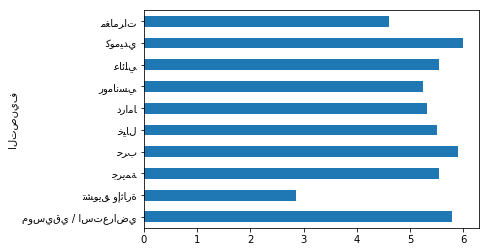

In [546]:
ratings_added_40s.groupby('التصنيف')['التقييم'].mean().plot.barh()


### What are the average ratings with respect to genres?

In [533]:
print('40s decade')
print(ratings_added_50s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('50s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('-----------------')
print('60s decade')
print(ratings_added_60s.groupby(['التصنيف'])['المدة'].mean())
print('70s decade')
print('-----------------')
print(ratings_added_70s.groupby(['التصنيف'])['المدة'].mean())

40s decade
التصنيف
تاريخي               106.500000
موسيقي / استعراضي    111.477419
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ         105.828571
ﺟﺮﻳﻤﺔ                113.900000
ﺣﺮﺏ                  103.500000
ﺣﺮﻛﺔ                 107.666667
ﺧﻴﺎﻝ                  95.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            104.333333
ﺩﺭاﻣﺎ                109.020833
ﺭﻋﺐ                  137.000000
ﺭﻭﻣﺎﻧﺴﻲ              108.729545
ﻋﺎﺋﻠﻲ                106.000000
ﻏﻤﻮﺽ                 101.000000
ﻛﻮﻣﻴﺪﻱ               107.620000
ﻣﻐﺎﻣﺮاﺕ              142.000000
Name: المدة, dtype: float64
-----------------
50s decade
التصنيف
تاريخي               118.500000
موسيقي / استعراضي    104.800000
ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ          99.761111
ﺟﺮﻳﻤﺔ                106.508333
ﺣﺮﻛﺔ                  96.428571
ﺧﻴﺎﻝ                 107.000000
ﺧﻴﺎﻝ ﻋﻠﻤﻲ            112.500000
ﺩﺭاﻣﺎ                105.535088
ﺭﻭﻣﺎﻧﺴﻲ              105.571739
ﺳﻴﺮﺓ ﺫاﺗﻴﺔ           133.900000
ﻋﺎﺋﻠﻲ                 96.250000
ﻏﻤﻮﺽ                  95.000000
ﻗﺼﻴﺮ                  30.000000
ﻛﻮﻣﻴﺪﻱ              

### Who made movie music the most?

In [532]:
print(movies_df['موسيقى'].value_counts().head())

فؤاد الظاهري                   102
أندريا رايدر (أندريه رايدر)     37
علي إسماعيل                     31
عمر خورشيد                      31
جمال سلامة                      28
Name: موسيقى, dtype: int64
